In [1]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [2]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=1      # which GPU to use
plot=True # Plot Intermediate results
sigma=10   # Initial model smoothness 
gpu_ids=[0,1]

# Inversion parameters
num_batches = 29
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 25
dx = 10
nt = 400
dt = 2/nt
num_shots = 29
num_receivers_per_shot = 300

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [3]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
import torch.nn as nn

In [4]:
#plot=True
# Load the true model
kk=2
filename='/glb/data/eptr_am_2/Arnab/FCNVMB_Deepwave/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
mat=scipy.io.loadmat(filename)['vmodel']
mat=mat[:-1,:-1]
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max=np.max(mat)
min=np.min(mat)
med=(max+min)/2.
wid=(max-min)/2.

print('vmin=',min,'vmax=',max,'vmed=',med,'vwidth=',wid)

vmin= 2144.5940488240713 vmax= 4500.0 vmed= 3322.2970244120356 vwidth= 1177.7029755879644


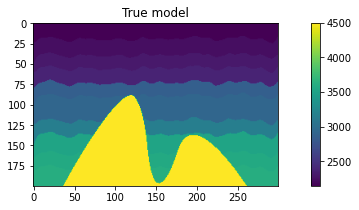

In [5]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min,vmax=max, aspect=1)
    plt.title('True model')
    plt.colorbar()

In [6]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [7]:
# Set parameters
##freq = 14
##dx = 10
##dt = 0.001

#RB nt = int(2 / dt) # 2s
#nt = int(0.9 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt))
#nt =       3 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt)
##nt = 4001

num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


ny= 300 nz= 200 nt= 400 dx= 10 freq= 25
shots= 29 recs/shot= 300 ds= 103.44827586206897 dr= 10.0


In [8]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [9]:
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [10]:
receiver_amplitudes_all.shape

torch.Size([400, 29, 300])

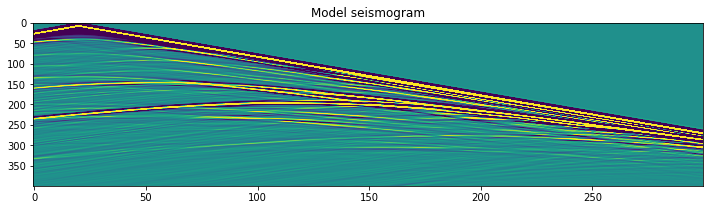

In [11]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [13]:
vel=mat
seis=receiver_amplitudes_all
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainvel/'+str(kk)+'.npy','wb')
np.save(file1,vel)
file1.close()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainseis/'+str(kk)+'.npy','wb')
np.save(file1,seis)
file1.close()

In [14]:
np.shape(seis)

torch.Size([800, 29, 300])

In [15]:
np.shape(vel)

(200, 300)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam([  # parameters which need optimization
                        {'params':model.encoder.parameters()},
                        {'params':model.decoder.parameters()}
                        ], lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1/3, patience=3, verbose=True)

In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = 0
    ###################
    # train the model #
    ###################
    #loop = tqdm(train_loader, total=len(train_loader))
    for batch in loop:
        images = batch[0].to(device)
        _, outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        loop.set_description(f'Epoch [{epoch+1:2d}/{num_epochs}]')
        loop.set_postfix(loss=train_loss)

    scheduler.step(train_loss)